## Overview

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
from collections import Counter
import sqlite3

## Data Loading
df = pd.read_csv("OnlineRetail.csv", encoding="ISO-8859-1")

print(f"Shape: {df.shape}")
print("\nFirst few rows:")
print(df.head)

Shape: (541909, 8)

First few rows:
<bound method NDFrame.head of        InvoiceNo StockCode                          Description  Quantity  \
0         536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1         536365     71053                  WHITE METAL LANTERN         6   
2         536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3         536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4         536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   
...          ...       ...                                  ...       ...   
541904    581587     22613          PACK OF 20 SPACEBOY NAPKINS        12   
541905    581587     22899         CHILDREN'S APRON DOLLY GIRL          6   
541906    581587     23254        CHILDRENS CUTLERY DOLLY GIRL          4   
541907    581587     23255      CHILDRENS CUTLERY CIRCUS PARADE         4   
541908    581587     22138        BAKING SET 9 PIECE RETROSPOT          3   

         

In [2]:
## Initial Exploration

print("\nColumn Info:")
print(df.info())
 
print("\nBasic Statistics:")
print(df.describe())

print("\nMissing Values:")
print(df.isnull().sum())

#Check unique values in key columns
print(f"\nUnique Invoices: {df['InvoiceNo'].nunique()}")
print(f"Unique Products: {df['StockCode'].nunique()}")
print(f"Unique Customers: {df['CustomerID'].nunique()}")



Column Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB
None

Basic Statistics:
            Quantity      UnitPrice     CustomerID
count  541909.000000  541909.000000  406829.000000
mean        9.552250       4.611114   15287.690570
std       218.081158      96.759853    1713.600303
min    -80995.000000  -11062.060000   12346.000000
25%         1.000000       1.250000   13953.000000
50%         3.000000       2.080000   15152.000000
75

In [3]:
## Data cleaning

print(f"Original dataset size: {len(df)}")

# Remove rows with missing cusomter ID

df_clean = df.dropna(subset=['CustomerID'])
print(f"Size after missing CustomerID: {len(df_clean)}")

# Remove cancelled orders
df_clean = df_clean[~df_clean['InvoiceNo'].astype(str).str.startswith('C')]
print(f"After removing cancelled orders: {len(df_clean)}")

# Remove rows with negative or zero quantities 
df_clean = df_clean[df_clean['Quantity'] > 0]
print (f"After removing negative/zero quantities: len{df_clean}")

# Remove rows with negative prices 
df_clean = df_clean[df_clean['UnitPrice'] > 0]
print (f"After removing negative prices: {len(df_clean)}")

# Remove rows with missing Description
df_clean = df_clean.dropna(subset=['Description'])
print(f"After removing missing descriptions: {len(df_clean)}")

# Stripping whitespace from Description and converting to uppercase
df_clean['Description'] = df_clean['Description'].str.strip().str.upper()

print(f"\nFinal cleaned dataset size: {len(df_clean)}")
print(f"Percentage retained: {len(df_clean)/len(df)*100:.2f}%")

Original dataset size: 541909
Size after missing CustomerID: 406829
After removing cancelled orders: 397924
After removing negative/zero quantities: len       InvoiceNo StockCode                          Description  Quantity  \
0         536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1         536365     71053                  WHITE METAL LANTERN         6   
2         536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3         536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4         536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   
...          ...       ...                                  ...       ...   
541904    581587     22613          PACK OF 20 SPACEBOY NAPKINS        12   
541905    581587     22899         CHILDREN'S APRON DOLLY GIRL          6   
541906    581587     23254        CHILDRENS CUTLERY DOLLY GIRL          4   
541907    581587     23255      CHILDRENS CUTLERY CIRCUS PARADE         4   
5

In [4]:
#Create in-memory SQLite database and load cleaned data into it

conn = sqlite3.connect(':memory:')

df_clean.to_sql('retail_data', conn, index=False, if_exists='replace')

#Find top 20 best selling products by quantity
query1 = """
SELECT 
    Description,
    SUM(Quantity) as TotalQuantity,
    COUNT(DISTINCT InvoiceNo) as NumTransactions,
    ROUND(AVG(UnitPrice), 2) as AvgPrice
FROM retail_data
GROUP BY Description
ORDER BY TotalQuantity DESC
LIMIT 20;
"""
top_products_sql = pd.read_sql_query(query1, conn)
print(top_products_sql)

                           Description  TotalQuantity  NumTransactions  \
0          PAPER CRAFT , LITTLE BIRDIE          80995                1   
1       MEDIUM CERAMIC TOP STORAGE JAR          77916              195   
2    WORLD WAR 2 GLIDERS ASSTD DESIGNS          54415              472   
3              JUMBO BAG RED RETROSPOT          46181             1600   
4   WHITE HANGING HEART T-LIGHT HOLDER          36725             1971   
5        ASSORTED COLOUR BIRD ORNAMENT          35362             1375   
6      PACK OF 72 RETROSPOT CAKE CASES          33693             1029   
7                       POPCORN HOLDER          30931              632   
8                   RABBIT NIGHT LIGHT          27202              801   
9               MINI PAINT SET VINTAGE          26076              325   
10           PACK OF 12 LONDON TISSUES          25345              382   
11  PACK OF 60 PINK PAISLEY CAKE CASES          24264              669   
12                  BROCADE RING PURSE

In [5]:
# Top 20 customers by total spending 

query2 = """
SELECT 
    CustomerID,
    COUNT(DISTINCT InvoiceNo) as NumOrders,
    SUM(Quantity * UnitPrice) as TotalSpending,
    ROUND(AVG(Quantity * UnitPrice), 2) as AvgOrderValue
FROM retail_data
GROUP BY CustomerID
ORDER BY TotalSpending DESC
LIMIT 20;
"""
top_customers_sql = pd.read_sql_query(query2, conn)
print(top_customers_sql)

    CustomerID  NumOrders  TotalSpending  AvgOrderValue
0      14646.0         73      280206.02         134.97
1      18102.0         60      259657.30         602.45
2      17450.0         46      194550.79         577.30
3      16446.0          2      168472.50       56157.50
4      14911.0        201      143825.06          25.34
5      12415.0         21      124914.53         174.95
6      14156.0         55      117379.63          83.84
7      17511.0         31       91062.38          94.56
8      16029.0         63       81024.84         334.81
9      12346.0          1       77183.60       77183.60
10     16684.0         28       66653.56         240.63
11     14096.0         17       65164.79          12.75
12     13694.0         50       65039.62         114.51
13     15311.0         91       60767.90          25.54
14     13089.0         97       58825.83          32.36
15     17949.0         45       58510.48         835.86
16     15769.0         26       56252.72        

In [6]:
# Products frequently bought together 

query3 = """
SELECT 
    r1.InvoiceNo,
    r1.Description as Product1,
    r2.Description as Product2
FROM retail_data r1
JOIN retail_data r2 
    ON r1.InvoiceNo = r2.InvoiceNo 
    AND r1.Description < r2.Description
LIMIT 20;
"""
sample_pairs_sql = pd.read_sql_query(query3, conn)
print(sample_pairs_sql)

   InvoiceNo                             Product1  \
0     536365   WHITE HANGING HEART T-LIGHT HOLDER   
1     536365       CREAM CUPID HEARTS COAT HANGER   
2     536365       CREAM CUPID HEARTS COAT HANGER   
3     536365       CREAM CUPID HEARTS COAT HANGER   
4     536365       CREAM CUPID HEARTS COAT HANGER   
5     536365       CREAM CUPID HEARTS COAT HANGER   
6     536365       CREAM CUPID HEARTS COAT HANGER   
7     536365  KNITTED UNION FLAG HOT WATER BOTTLE   
8     536365  KNITTED UNION FLAG HOT WATER BOTTLE   
9     536365  KNITTED UNION FLAG HOT WATER BOTTLE   
10    536365  KNITTED UNION FLAG HOT WATER BOTTLE   
11    536365       RED WOOLLY HOTTIE WHITE HEART.   
12    536365       RED WOOLLY HOTTIE WHITE HEART.   
13    536365       RED WOOLLY HOTTIE WHITE HEART.   
14    536365         SET 7 BABUSHKA NESTING BOXES   
15    536365         SET 7 BABUSHKA NESTING BOXES   
16    536365    GLASS STAR FROSTED T-LIGHT HOLDER   
17    536365    GLASS STAR FROSTED T-LIGHT HOL

In [7]:
# Group by InvoiceNo to get items purchased together

basket= df_clean.groupby(['InvoiceNo', 'Description'])['Quantity'].sum().unstack().fillna(0)

# Convert to binary where 1 is if item was purchased 0 if not
basket_binary = basket.map(lambda x: 1 if x > 0 else 0)

print(f"\nTotal transactions: {len(basket_binary)}")
print(f"Total unique products: {len(basket_binary.columns)}")

# Find most frequently purchased items
item_frequency = basket_binary.sum().sort_values(ascending=False)
print("\n Top 20 Most Frequently Purchased Items")
print(item_frequency.head(20))

# Find item pairs that appear together 
# Only use the top 50 most popular items for relevancy purposes

top_n = 50
top_items = item_frequency.head(top_n).index

# Filter basket to only include top items
basket_top = basket_binary[top_items]

# Find all pairs and count co-occurances
pair_counts = []
for transaction in basket_top.values:
    items_in_transaction = top_items[transaction > 0]
    if len(items_in_transaction) >= 2:
        for pair in combinations(items_in_transaction, 2):
            pair_counts.append(tuple(sorted(pair)))

# Count frequency of each pair
pair_frequency = Counter(pair_counts)

# Convert to DataFrame for easier analysis
pairs_df = pd.DataFrame(pair_frequency.items(), columns=['Item_Pair', 'Frequency'])
pairs_df[['Item_1', 'Item_2']] = pd.DataFrame(pairs_df['Item_Pair'].tolist(), index=pairs_df.index)
pairs_df = pairs_df[['Item_1', 'Item_2', 'Frequency']].sort_values('Frequency', ascending=False)

print("\nTop 20 Item Pairs Purchased Together:")
print(pairs_df.head(20))

# Calculate support (percentage of transactions containing he pair)

pairs_df['Support'] = pairs_df['Frequency'] / len(basket_binary) * 100

print("\nTop 20 Item Pairs with Support (%)")
print(pairs_df.head(20))


Total transactions: 18532
Total unique products: 3866

 Top 20 Most Frequently Purchased Items
Description
WHITE HANGING HEART T-LIGHT HOLDER    1971
REGENCY CAKESTAND 3 TIER              1703
JUMBO BAG RED RETROSPOT               1600
PARTY BUNTING                         1379
ASSORTED COLOUR BIRD ORNAMENT         1375
LUNCH BAG RED RETROSPOT               1288
SET OF 3 CAKE TINS PANTRY DESIGN      1146
POSTAGE                               1099
LUNCH BAG  BLACK SKULL.               1052
PACK OF 72 RETROSPOT CAKE CASES       1029
SPOTTY BUNTING                        1003
LUNCH BAG SPACEBOY DESIGN              988
PAPER CHAIN KIT 50'S CHRISTMAS         980
NATURAL SLATE HEART CHALKBOARD         967
LUNCH BAG CARS BLUE                    966
HEART OF WICKER SMALL                  961
LUNCH BAG PINK POLKADOT                931
LUNCH BAG SUKI DESIGN                  899
JAM MAKING SET WITH JARS               878
ALARM CLOCK BAKELIKE RED               877
dtype: int64

Top 20 Item Pairs 

SaveedL top_products.png


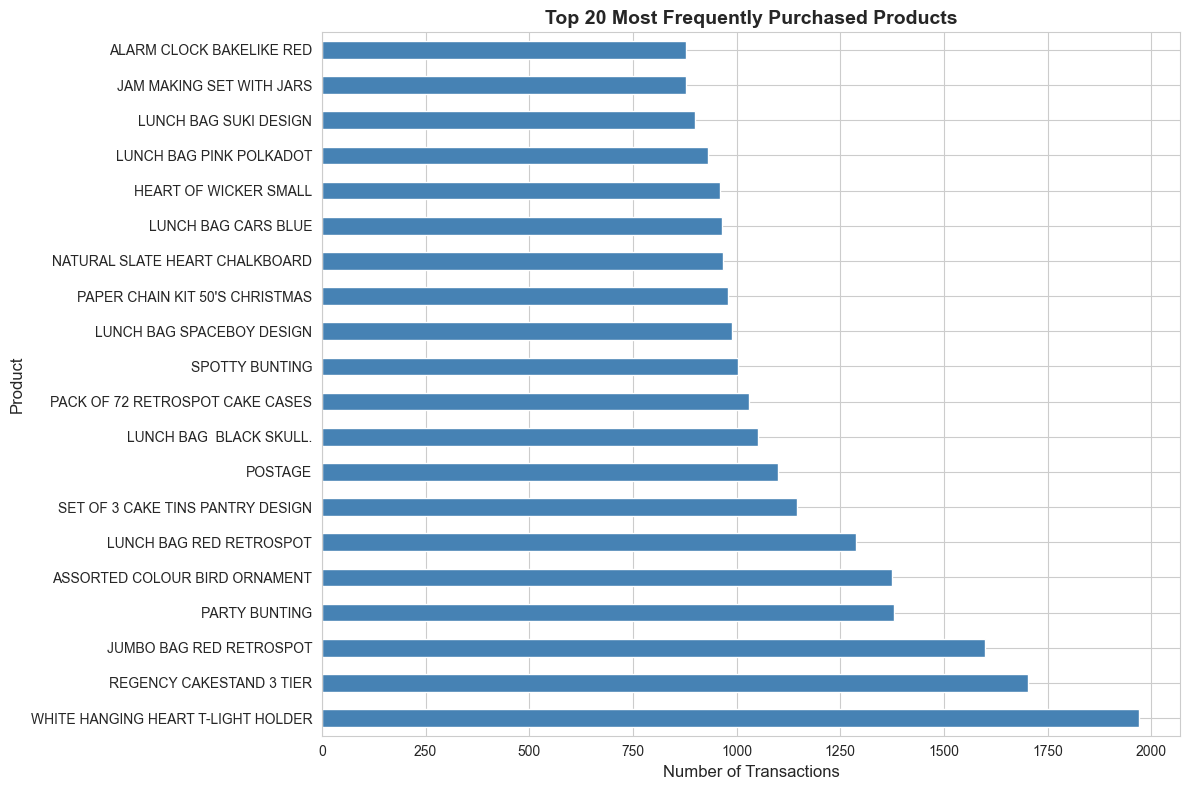

In [9]:
# Visualizations 

# Style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# Top 20 Products
fig, ax = plt.subplots(figsize=(12,8))
item_frequency.head(20).plot(kind='barh', ax=ax, color='steelblue')
ax.set_xlabel('Number of Transactions', fontsize=12)
ax.set_ylabel('Product', fontsize=12)
ax.set_title('Top 20 Most Frequently Purchased Products', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('top_products.png', dpi=300, bbox_inches='tight')
print("SaveedL top_products.png")
plt.show()

Saved: top_pairs.png


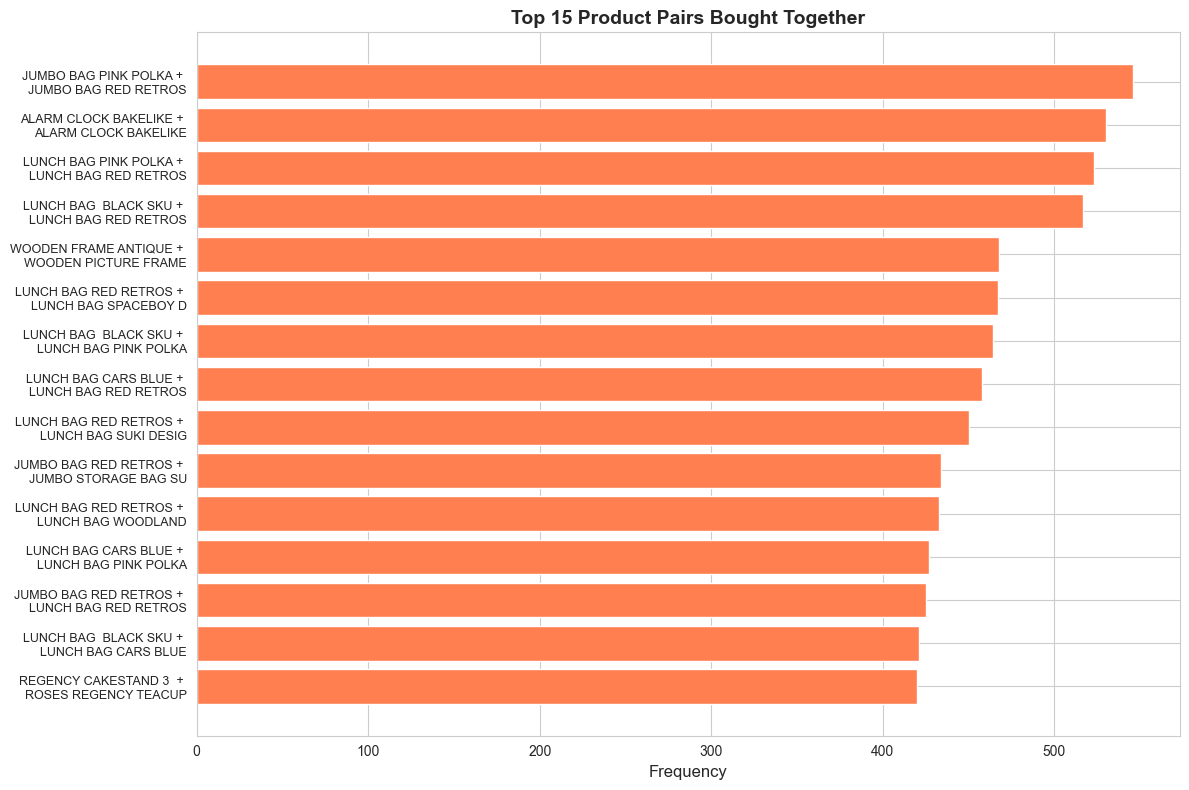

In [11]:
# Top 15 Product Pairs

fig, ax = plt.subplots(figsize=(12, 8))
top_pairs = pairs_df.head(15).copy()
top_pairs['Pair_Label'] = top_pairs['Item_1'].str[:20] + ' + \n' + top_pairs['Item_2'].str[:20]
ax.barh(range(len(top_pairs)), top_pairs['Frequency'], color='coral')
ax.set_yticks(range(len(top_pairs)))
ax.set_yticklabels(top_pairs['Pair_Label'], fontsize=9)
ax.set_xlabel('Frequency', fontsize=12)
ax.set_title('Top 15 Product Pairs Bought Together', fontsize=14, fontweight='bold')
ax.invert_yaxis()
plt.tight_layout()
plt.savefig('top_pairs.png', dpi=300, bbox_inches='tight')
print("Saved: top_pairs.png")
plt.show()

Saved: cooccurrence_heatmap.png


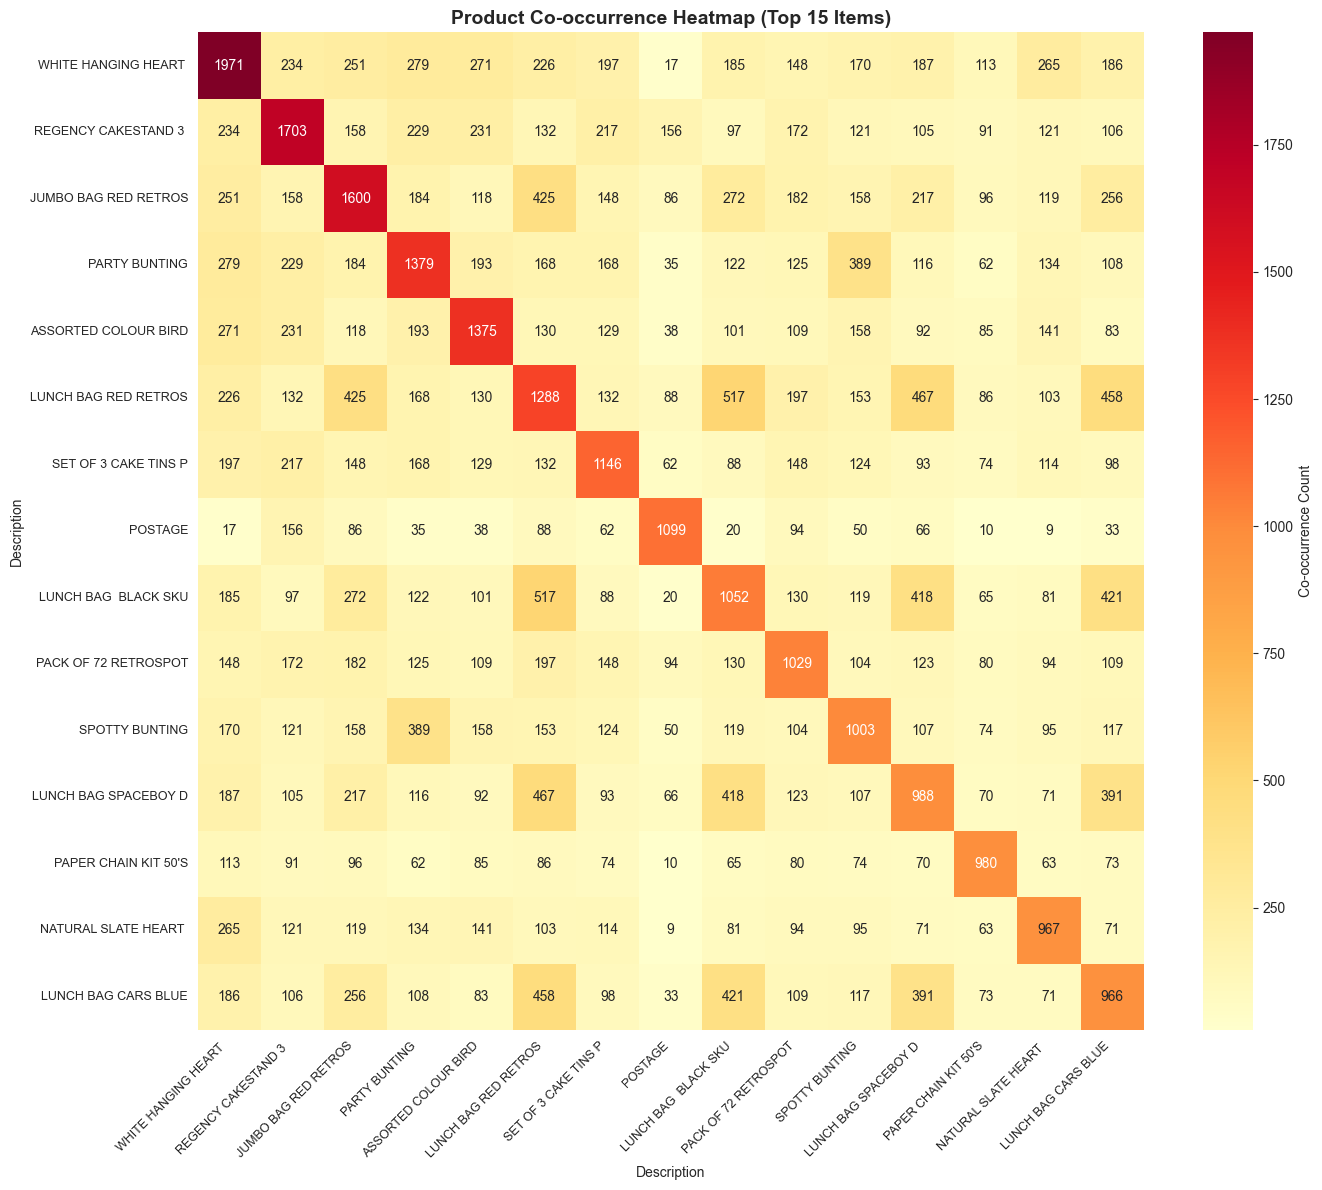

In [15]:
# Co occurance heatmap
top_15_items = item_frequency.head(15).index
basket_top_15 = basket_binary[top_15_items]

# Create co-occurrence matrix
co_occurrence = basket_top_15.T.dot(basket_top_15)

# Create heatmap
fig, ax = plt.subplots(figsize=(14, 12))
sns.heatmap(co_occurrence, annot=True, fmt='d', cmap='YlOrRd', 
            xticklabels=[item[:20] for item in top_15_items],
            yticklabels=[item[:20] for item in top_15_items],
            ax=ax, cbar_kws={'label': 'Co-occurrence Count'})
ax.set_title('Product Co-occurrence Heatmap (Top 15 Items)', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right', fontsize=9)
plt.yticks(rotation=0, fontsize=9)
plt.tight_layout()
plt.savefig('cooccurrence_heatmap.png', dpi=300, bbox_inches='tight')
print("Saved: cooccurrence_heatmap.png")
plt.show()

In [ ]:
# Export

# Save cleaned data
df_clean.to_csv('cleaned_retail_data.csv', index=False)
print('Saved: cleaned_retail_data.csv')

# Save SQL results
top_products_sql.to_csv('sql_top_produts.csv', index=False)
print("Saved: sql_top_products.csv")

top_customers_sql.to_csv('sql_top_customers.csv', index=False)
print("Saved: sql_top_customers.csv")

# Save top 50 products
item_frequency.head(50).to_csv('top_products.csv', header=['Frequency'])
print("Saved: top_products.csv")

# Save top pairs
pairs_df.head(50).to_csv("top_product_pairs.csv", index=False)
print("Saved: top_product_pairs.csv")

print("\nSummary Statistics:")
print(f"- Total transactions analyzed: {len(basket_binary):,}")
print(f"- Unique products: {len(basket_binary.columns):,}")
print(f"- Most popular product: {item_frequency.index[0]}")
print(f"- Most common pair: {pairs_df.iloc[0]['Item_1'][:30]} + {pairs_df.iloc[0]['Item_2'][:30]}")
print(f"- Pair frequency: {pairs_df.iloc[0]['Frequency']} transactions")

Saved: cleaned_retail_data.csv
Saved: sql_top_products.csv
Saved: sql_top_customers.csv
Saved: top_products.csv
Saved: top_product_pairs.csv

Statistics Summary:
- Total transactions analyzed: 18,532
- Unique products: 3,866
- Most popular product: WHITE HANGING HEART T-LIGHT HOLDER
- Most common pair: JUMBO BAG PINK POLKADOT + JUMBO BAG RED RETROSPOT
- Pair frequency: 546 transactions
